<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/Self_Attention_stepBystep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exemplo de self attention

In [1]:
import torch 
import numpy as np
import seaborn as sns

In [2]:
# ====
# 0
# ====

# -- ENTRADA:
text = 'Quero um cartão'
text_tokens = ['Quero', 'um', 'cartão']

# -- IDs:
text_ids = [27,11,83] # tokens sintéticos
VOCAB = 100 # Quantidade de palavras - no BERT ~30k

# -- DIMENSÃO DOS EMBEDDINGS = 4:
D = 8

# -- COMPRIMENTO DA SEQUÊNCIA:
L = 3

# -- NÚMERO DE CABEÇAS:
H = 2

# -- MATRIZ DE EMBEDDINGS LxD:
embs  = torch.nn.Embedding(VOCAB, D)

# tensor com zeros_like
embeddings = torch.zeros(len(text_ids) * D).reshape(len(text_ids), D)
print(f'Shape da matriz de embeddings: {embeddings.shape}\n')

print('Matriz de embeddings\n')
for i , token in enumerate(text_ids):
    embeddings[i] = embs(torch.tensor(token))
embeddings

Shape da matriz de embeddings: torch.Size([3, 8])

Matriz de embeddings



tensor([[-0.6716, -0.8052, -1.3753, -0.9598, -0.8162, -1.0743, -1.1493,  1.0052],
        [-1.2672,  0.8590,  0.7650, -0.1225, -0.4680, -0.1172,  0.8682,  0.7488],
        [ 0.0959, -0.7437, -0.8650, -0.1754, -0.2658, -0.7284,  0.4719, -0.9366]],
       grad_fn=<AsStridedBackward>)

In [3]:
# ====
# 1
# ====

# -- MATRIZ DE PESOS, Q, K, V --> DxD (INICIADOS ARBITRARIAMENTE):
Qw = torch.nn.Linear(D, D)
Kw = torch.nn.Linear(D, D)
Vw = torch.nn.Linear(D, D)

print('Qw', Qw.weight, '\n')
print('Kw', Qw.weight, '\n')
print('Vw', Qw.weight, '\n')

Qw Parameter containing:
tensor([[ 2.1355e-01, -6.0505e-02,  1.5879e-01, -1.8780e-01, -3.2963e-01,
         -1.3225e-01, -3.1237e-01,  4.1349e-02],
        [ 4.3815e-02, -3.3955e-01, -1.8005e-01,  9.7164e-02,  3.2993e-02,
         -3.4433e-01, -2.8679e-01,  2.6753e-01],
        [-1.0233e-04, -2.2486e-01,  8.0195e-02,  2.2640e-01,  3.3849e-01,
         -2.1087e-01,  8.0766e-03, -1.8503e-01],
        [-1.4945e-01, -7.7578e-02, -2.7284e-01,  3.0345e-01, -1.2821e-01,
          7.4291e-02,  2.9289e-01, -1.3037e-01],
        [-1.5207e-01,  2.5239e-01, -4.9343e-02, -2.7299e-01,  3.4929e-01,
          3.4996e-02,  1.0453e-01, -1.6502e-01],
        [ 1.7923e-01, -7.4382e-03,  9.8489e-02, -4.1425e-02,  1.3294e-01,
         -1.2020e-01,  9.6759e-02,  5.5211e-02],
        [-2.5398e-01,  1.2795e-01,  9.5807e-02, -1.5399e-01,  2.8151e-01,
         -3.3101e-01, -4.1829e-02,  1.7249e-01],
        [ 3.4974e-01,  3.3948e-01,  1.9345e-01, -2.7108e-01, -5.8042e-02,
         -3.0578e-01, -1.4480e-01,  1.30

In [5]:
# ====
# 2
# ====

# -- OBTER Q, K e V:
print(f'Shape da entrada: {embeddings.size()} -- Shape das Matrizes de pesos Qw, Kw e Vw: {Qw.weight.size()}')

Q =  torch.einsum('ld, de -> le', embeddings, Kw.weight) 
K =  torch.einsum('ld, de -> le', embeddings, Vw.weight) 
V =  torch.einsum('ld, de -> le', embeddings, Qw.weight) 

dk = D//H
Q = Q.reshape(L, H, dk)
K = K.reshape(L, H, dk)
V = V.reshape(L, H, dk)

print('Q', Q.size())
print('K', K.size())
print('V', V.size())

Shape da entrada: torch.Size([3, 8]) -- Shape das Matrizes de pesos Qw, Kw e Vw: torch.Size([8, 8])
Q torch.Size([3, 2, 4])
K torch.Size([3, 2, 4])
V torch.Size([3, 2, 4])


In [6]:
# ====
# 3
# ====

Q = Q.transpose(0,1) # (H, L, dk)
K = K.transpose(0,1) # (H, L, dk)
V = V.transpose(0,1) # (H, L, dk)

print('Q', Q.size())
print('K', K.size())
print('V', V.size())

Q torch.Size([2, 3, 4])
K torch.Size([2, 3, 4])
V torch.Size([2, 3, 4])


In [8]:
# ====
# 4
# ====

# -- CALCULAR O SCORE:    
QKT = torch.einsum('hld, hcd -> hlc', Q, K) # K.transpose(-2,-1)=(H, dk, L) := (H, L, dk)x(H, dk, L) = (H, L, L)
print('SCORE', QKT.size())

# -- DIVIDIR POR SQRT(D)

# -- SOFTMAX:
Softmax = torch.nn.Softmax(dim=-1)
Softmax = Softmax(QKT.float())
SCORE = QKT/torch.sqrt(torch.tensor(D)) # (H, L, L) 

SCORE torch.Size([2, 3, 3])


In [9]:
# ====
# 5
# ====

SV = torch.einsum('hlc, hck -> hlk', SCORE, V) # (H, L, L)x(H, L, D//H)=(H, L, D//H)
print('SV', SV.size()) 

SV torch.Size([2, 3, 4])


In [10]:
# ====
# 6
# ====

SV = SV.transpose(0,1) # (L, H, dk)
print('SV', SV.size())

SV torch.Size([3, 2, 4])


In [11]:
# ====
# 7
# ====

SV = SV.reshape(L, -1) # (L, H*dk)
print('SV', SV.size())

# -- MULTIPLICAR PELA MATRIZ DE PROJEÇÃO Wo
Wow = torch.nn.Linear(D, D)

SV torch.Size([3, 8])


In [12]:
# ====
# 8
# ====

## -- SV @ Wo = MATRIZ DE ATENÇÃO:
ATT = torch.einsum('ld, dm -> lm', SV, Wow.weight) # (L, D)x(DxD)
print('ATT', ATT.size())
ATT

ATT torch.Size([3, 8])


tensor([[-0.0210, -0.0109, -0.0485,  0.0004, -0.1306,  0.0589, -0.0236, -0.0703],
        [ 0.0409,  0.0892,  0.0456,  0.2058,  0.0655, -0.0473, -0.0212,  0.0232],
        [-0.0335, -0.0202, -0.0561, -0.0754, -0.0971,  0.0393, -0.0274, -0.0595]],
       grad_fn=<ViewBackward>)

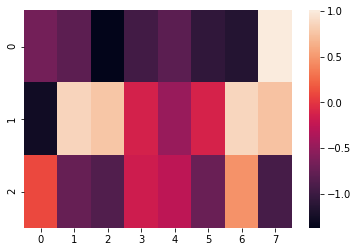

In [15]:
# Embs sem ATT
sns.heatmap(embeddings.detach().numpy())

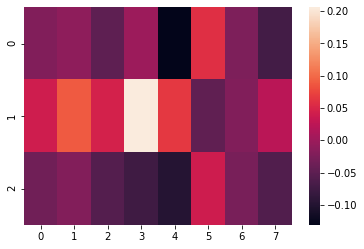

In [16]:
# ATT Embs
sns.heatmap(ATT.detach().numpy())

# Fim do Notebook